# GRU Final with validation spit 0.1

Epoch 1/50
36/36 [==============================] - 15s 213ms/step - loss: 0.0155 - val_loss: 9.9585e-04 - lr: 0.0010
Epoch 2/50
36/36 [==============================] - 9s 240ms/step - loss: 7.9644e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 3/50
36/36 [==============================] - 7s 185ms/step - loss: 6.5648e-04 - val_loss: 9.5088e-04 - lr: 0.0010
Epoch 4/50
36/36 [==============================] - 9s 239ms/step - loss: 5.9413e-04 - val_loss: 7.0815e-04 - lr: 0.0010
Epoch 5/50
36/36 [==============================] - 8s 222ms/step - loss: 5.1871e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 6/50
36/36 [==============================] - 10s 275ms/step - loss: 5.6059e-04 - val_loss: 5.7112e-04 - lr: 0.0010
Epoch 7/50
36/36 [==============================] - 9s 239ms/step - loss: 4.3382e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 8/50
36/36 [==============================] - 7s 190ms/step - loss: 3.9875e-04 - val_loss: 5.8297e-04 - lr: 0.0010
Epoch 9/50
36/36 [============================

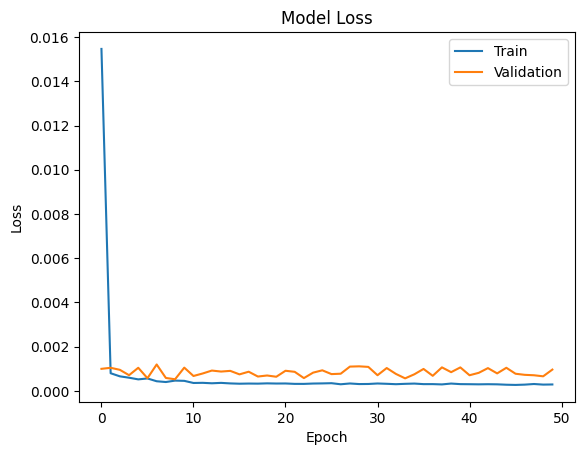

10/10 [==============================] - 2s 58ms/step
Mean Squared Error (MSE) - GRU: 2295.83
Root Mean Squared Error (RMSE) - GRU: 47.91
Mean Absolute Error (MAE) - GRU: 40.61
Mean Absolute Percentage Error (MAPE) - GRU: 1.69%


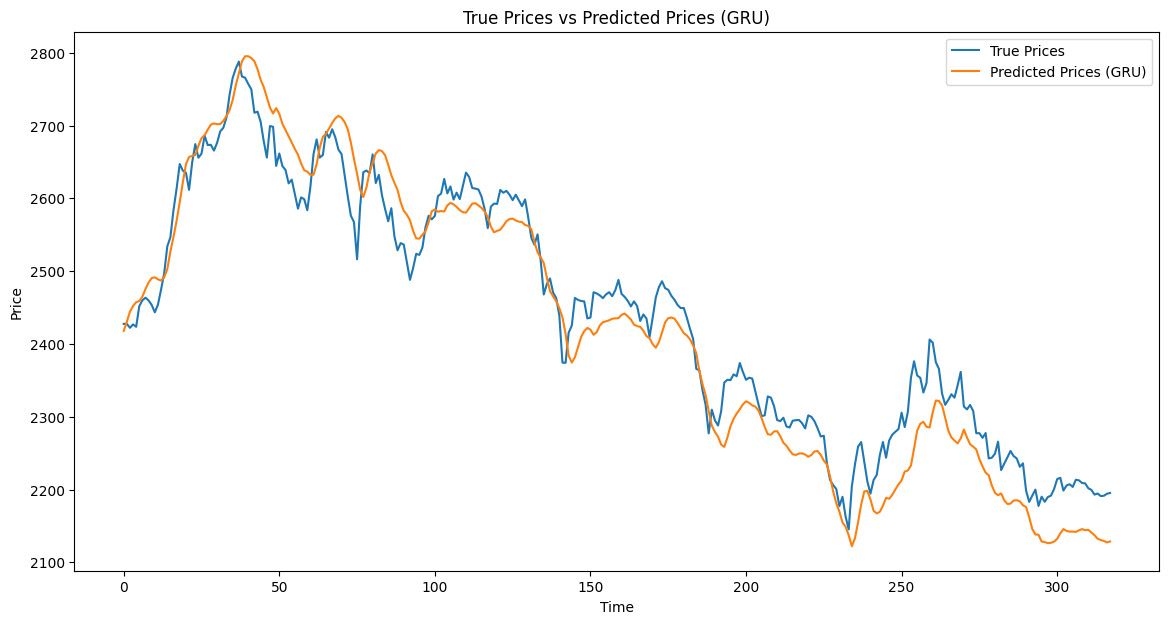

Accuracy of Predicted Prices (GRU): 93.68%
Mean Absolute Percentage Error (MAPE) - GRU: 1.69%


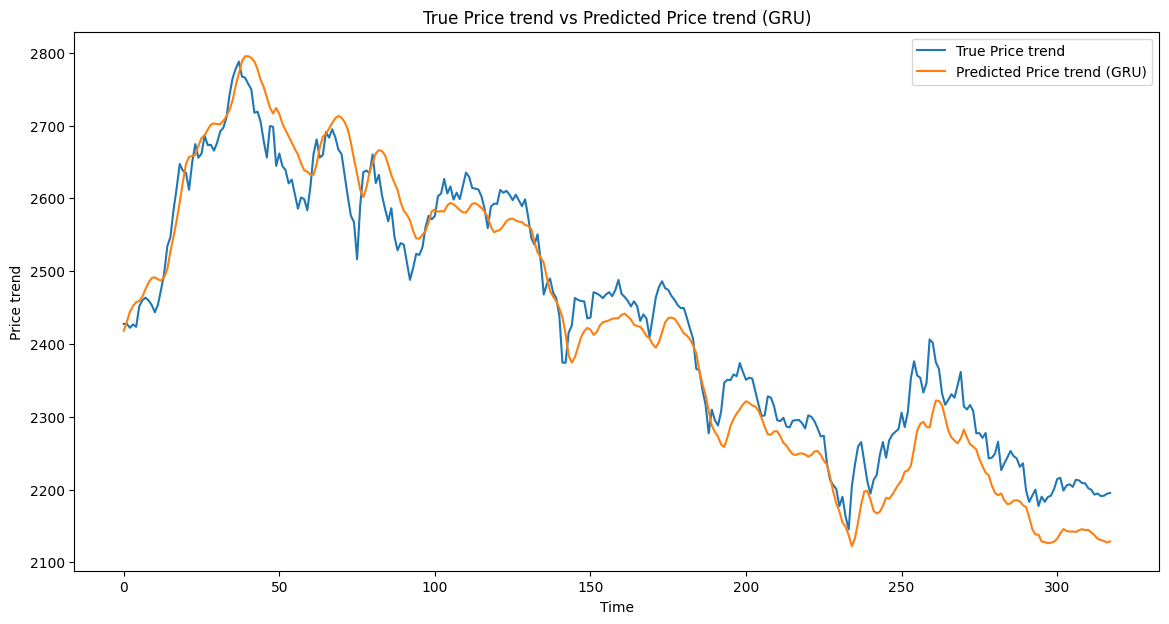

Accuracy of Predicted Prices (GRU): 93.68%


In [ ]:
import pandas as pd
import random
from keras.layers import GRU, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.dates as mdates
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python random module
random.seed(42)

# Read the CSV file and sort by date
df = pd.read_csv('7new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

# List of considered Features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance',
            'Unemployment Rate', 'Exchange Rate', 'Economic Growth']

# Create the dataset with features and filter the data to the list of FEATURES
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Generate training data and test data
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Prediction is based on the 'Price' column
    return np.array(x), np.array(y)

# Generate training and test data
x, y = partition_dataset(sequence_length, data_scaled)
split = math.ceil(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Configure the GRU model
model_gru = Sequential()
model_gru.add(GRU(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_gru.add(Dropout(0.15))
model_gru.add(GRU(128, return_sequences=False))
#model_gru.add(Dropout(0.1))
model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(1))

# Compile the GRU model
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # You can adjust the clip value as needed
model_gru.compile(optimizer=optimizer, loss='mse')

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the GRU model
history_gru = model_gru.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[ reduce_lr])

# Plot training & validation loss values
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Get the predicted values
y_pred_scaled_gru = model_gru.predict(x_test)
y_pred_gru = scaler.inverse_transform(np.concatenate((y_pred_scaled_gru, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate metrics
mse_gru = mean_squared_error(y_test_unscaled, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru = np.mean(np.abs(y_test_unscaled - y_pred_gru))
mape_gru = np.mean(np.abs((y_test_unscaled - y_pred_gru) / y_test_unscaled)) * 100

print(f'Mean Squared Error (MSE) - GRU: {mse_gru:.2f}')
print(f'Root Mean Squared Error (RMSE) - GRU: {rmse_gru:.2f}')
print(f'Mean Absolute Error (MAE) - GRU: {mae_gru:.2f}')
print(f'Mean Absolute Percentage Error (MAPE) - GRU: {mape_gru:.2f}%')

# Plot true prices and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled, label='True Prices')
plt.plot(y_pred_gru, label='Predicted Prices (GRU)')
plt.title('True Prices vs Predicted Prices (GRU)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate the absolute difference between true prices and predicted prices
absolute_difference_gru = np.abs(y_test_unscaled - y_pred_gru)

# Calculate the mean absolute difference
mean_absolute_difference_gru = np.mean(absolute_difference_gru)

# Calculate the range of prices
price_range_gru = np.max(y_test_unscaled) - np.min(y_test_unscaled)

# Calculate accuracy in percentage
accuracy_percentage_gru = (1 - (mean_absolute_difference_gru / price_range_gru)) * 100

print(f'Accuracy of Predicted Prices (GRU): {accuracy_percentage_gru:.2f}%')

print(f'Mean Absolute Percentage Error (MAPE) - GRU: {mape_gru:.2f}%')

# Plot true prices and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled, label='True Price trend')
plt.plot(y_pred_gru, label='Predicted Price trend (GRU)')
plt.title('True Price trend vs Predicted Price trend (GRU)')
plt.xlabel('Time')
plt.ylabel('Price trend')
plt.legend()
plt.show()

# Calculate the absolute difference between true prices and predicted prices
absolute_difference_gru = np.abs(y_test_unscaled - y_pred_gru)

# Calculate the mean absolute difference
mean_absolute_difference_gru = np.mean(absolute_difference_gru)

# Calculate the range of prices
price_range_gru = np.max(y_test_unscaled) - np.min(y_test_unscaled)

# Calculate accuracy in percentage
accuracy_percentage_gru = (1 - (mean_absolute_difference_gru / price_range_gru)) * 100

print(f'Accuracy of Predicted Prices (GRU): {accuracy_percentage_gru:.2f}%')


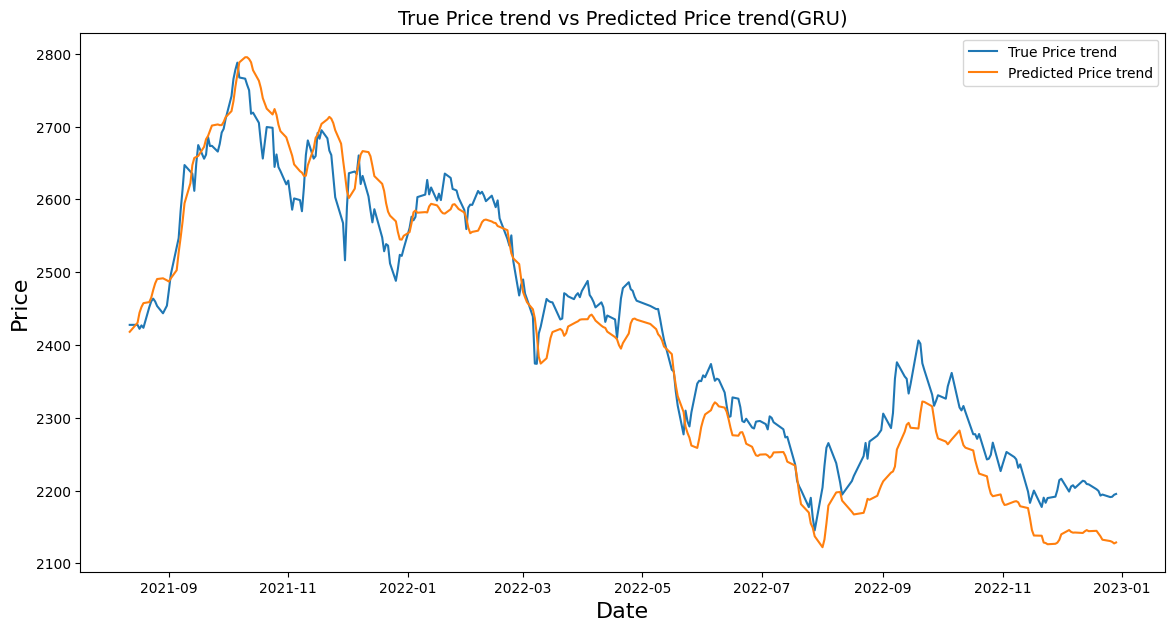

In [ ]:
# Plot true prices and predicted prices with dates on the x-axis
plt.figure(figsize=(14, 7))
plt.plot(df['Date'].iloc[-len(y_test_unscaled):], y_test_unscaled, label='True Price trend')
plt.plot(df['Date'].iloc[-len(y_pred_gru):], y_pred_gru, label='Predicted Price trend')
plt.title('True Price trend vs Predicted Price trend(GRU)', fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.legend()
plt.show()


#  BiLSTM with validation split 0.1


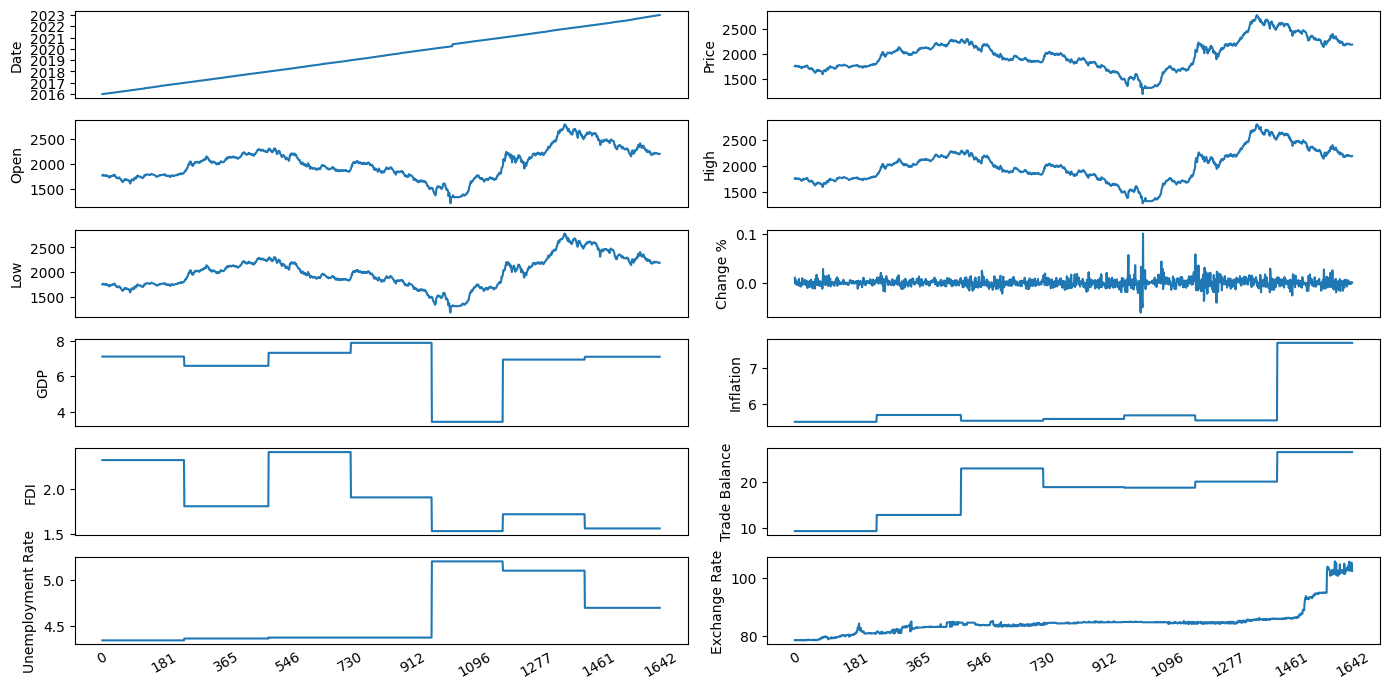

Epoch 1/50
36/36 [==============================] - 32s 653ms/step - loss: 0.0138 - val_loss: 0.0026 - lr: 0.0010
Epoch 2/50
36/36 [==============================] - 22s 598ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0010
Epoch 3/50
36/36 [==============================] - 22s 612ms/step - loss: 8.1567e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 4/50
36/36 [==============================] - 21s 582ms/step - loss: 5.9031e-04 - val_loss: 0.0033 - lr: 0.0010
Epoch 5/50
36/36 [==============================] - 22s 627ms/step - loss: 4.8053e-04 - val_loss: 8.8343e-04 - lr: 0.0010
Epoch 6/50
36/36 [==============================] - 21s 577ms/step - loss: 4.9070e-04 - val_loss: 0.0019 - lr: 0.0010
Epoch 7/50
36/36 [==============================] - 22s 621ms/step - loss: 4.0757e-04 - val_loss: 0.0021 - lr: 0.0010
Epoch 8/50
36/36 [==============================] - 21s 582ms/step - loss: 3.9829e-04 - val_loss: 9.9518e-04 - lr: 0.0010
Epoch 9/50
36/36 [==============================] - 22s 

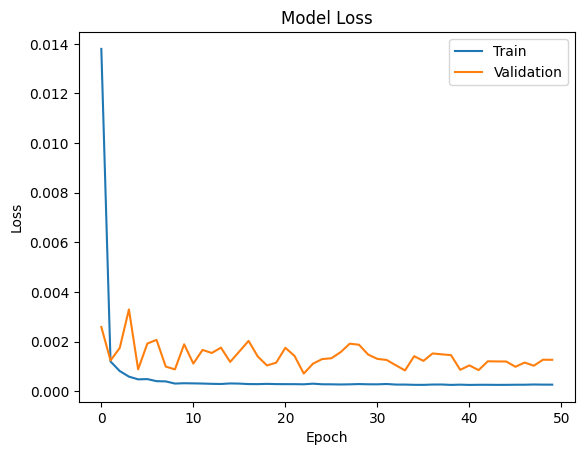

10/10 [==============================] - 3s 147ms/step
Mean Squared Error (MSE): 2105.73
Root Mean Squared Error (RMSE): 45.89
Mean Absolute Error (MAE): 32.73
Mean Absolute Percentage Error (MAPE): 1.32%


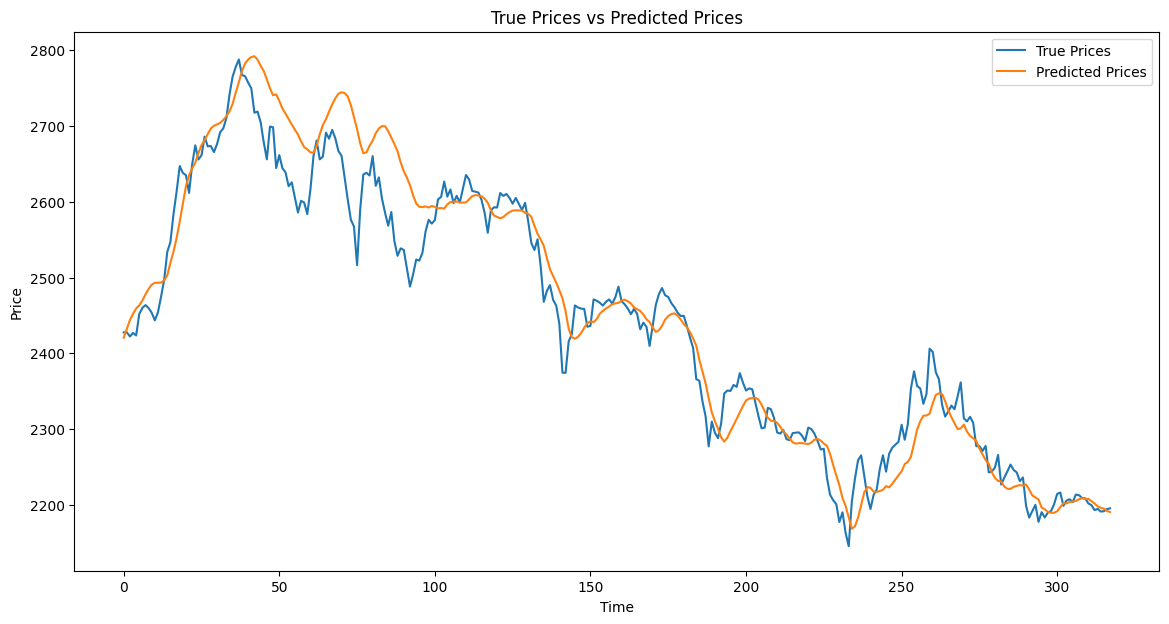

Accuracy of Predicted Prices: 94.91%


In [ ]:
import pandas as pd
import random
from keras.layers import Bidirectional
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python random module
random.seed(42)

# Read the CSV file and sort by date
df = pd.read_csv('7new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

# Plot line charts
df_plot = df.copy()
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
    sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
    ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# List of considered Features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance',
            'Unemployment Rate', 'Exchange Rate', 'Economic Growth']

# Create the dataset with features and filter the data to the list of FEATURES
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Generate training data and test data
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Prediction is based on the 'Price' column
    return np.array(x), np.array(y)

# Generate training and test data
x, y = partition_dataset(sequence_length, data_scaled)
split = math.ceil(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Configure the neural network model
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.15))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
#model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model with Adam optimizer and gradient clipping
optimizer = Adam(clipvalue=1.0)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='mse')

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Training the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate metrics
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))
mape = np.mean(np.abs((y_test_unscaled - y_pred) / y_test_unscaled)) * 100

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot true prices and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled, label='True Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title('True Prices vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
# Calculate the absolute difference between true prices and predicted prices
absolute_difference = np.abs(y_test_unscaled - y_pred)

# Calculate the mean absolute difference
mean_absolute_difference = np.mean(absolute_difference)

# Calculate the range of prices
price_range = np.max(y_test_unscaled) - np.min(y_test_unscaled)

# Calculate accuracy in percentage
accuracy_percentage = (1 - (mean_absolute_difference / price_range)) * 100

print(f'Accuracy of Predicted Prices: {accuracy_percentage:.2f}%')

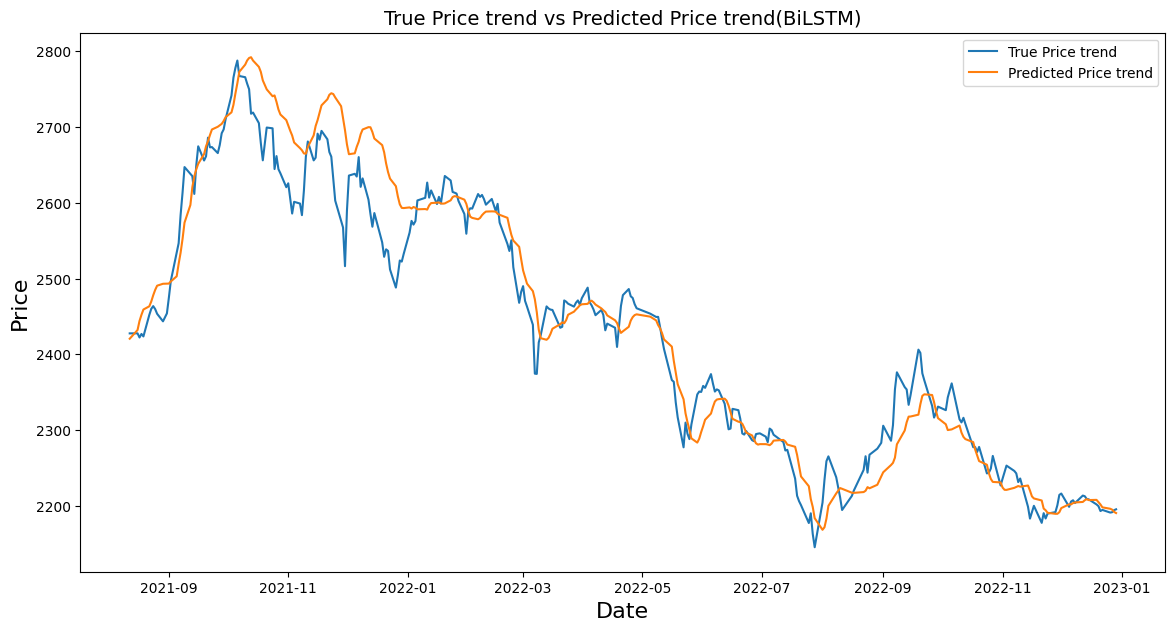

In [ ]:
# Plot true prices and predicted prices with dates on the x-axis
plt.figure(figsize=(14, 7))
plt.plot(df['Date'].iloc[-len(y_test_unscaled):], y_test_unscaled, label='True Price trend')
plt.plot(df['Date'].iloc[-len(y_pred):], y_pred, label='Predicted Price trend')
plt.title('True Price trend vs Predicted Price trend(BiLSTM)', fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.legend()
plt.show()


# LSTM with validation split 0.1

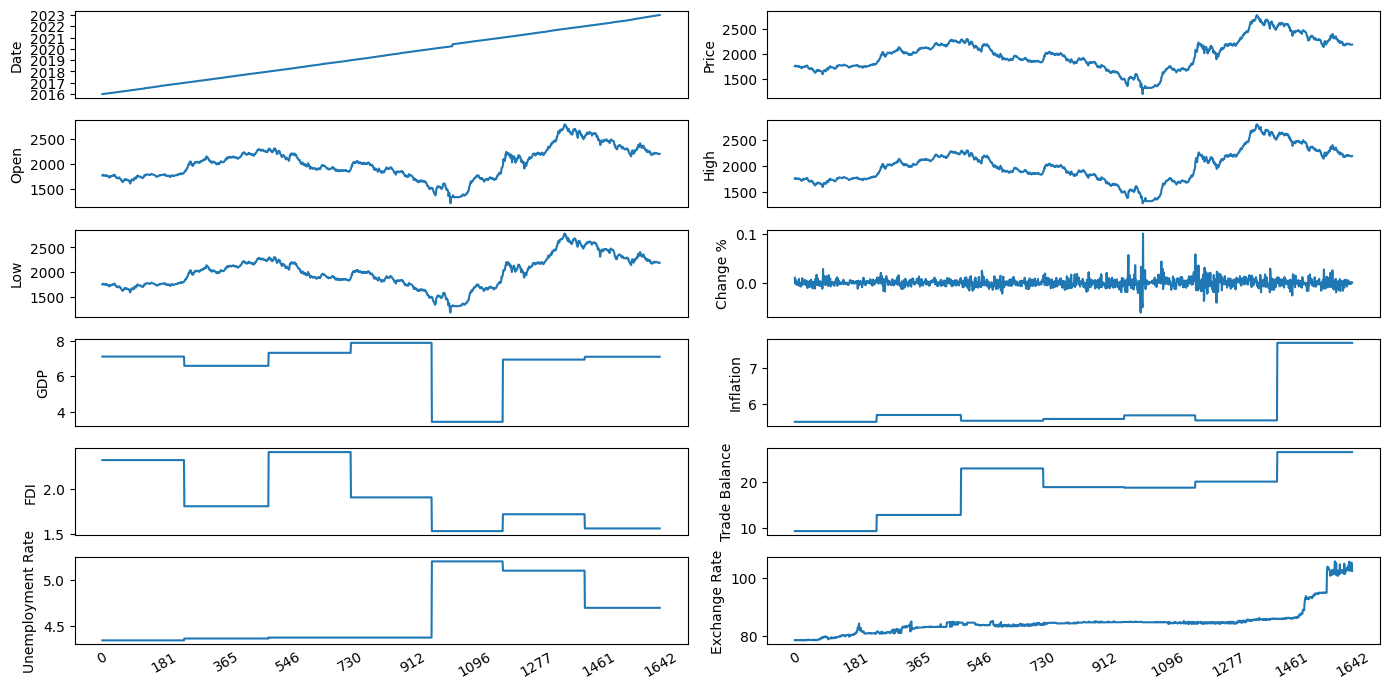

Epoch 1/50
36/36 [==============================] - 15s 306ms/step - loss: 0.0135 - val_loss: 0.0018 - lr: 0.0010
Epoch 2/50
36/36 [==============================] - 9s 238ms/step - loss: 9.9737e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 3/50
36/36 [==============================] - 10s 283ms/step - loss: 9.5021e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 4/50
36/36 [==============================] - 10s 280ms/step - loss: 7.4770e-04 - val_loss: 0.0035 - lr: 0.0010
Epoch 5/50
36/36 [==============================] - 9s 237ms/step - loss: 7.1726e-04 - val_loss: 0.0027 - lr: 2.0000e-04
Epoch 6/50
36/36 [==============================] - 11s 313ms/step - loss: 6.4140e-04 - val_loss: 0.0016 - lr: 2.0000e-04
Epoch 7/50
36/36 [==============================] - 10s 277ms/step - loss: 6.1631e-04 - val_loss: 0.0020 - lr: 2.0000e-04
Epoch 8/50
36/36 [==============================] - 9s 237ms/step - loss: 5.9915e-04 - val_loss: 0.0019 - lr: 2.0000e-04
Epoch 9/50
36/36 [=============================

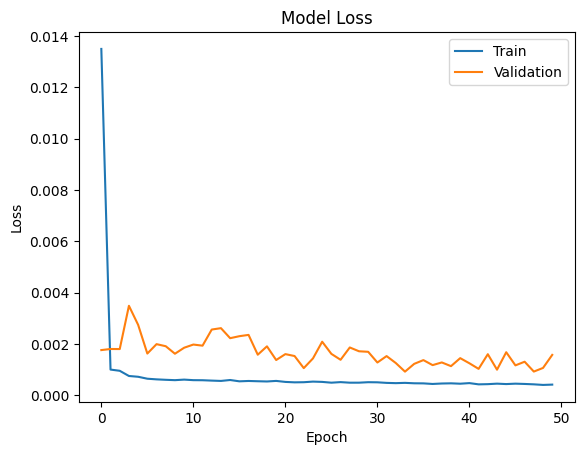

10/10 [==============================] - 2s 75ms/step
Mean Squared Error (MSE): 8619.95
Root Mean Squared Error (RMSE): 92.84
Mean Absolute Error (MAE): 83.33
Mean Absolute Percentage Error (MAPE): 3.42%


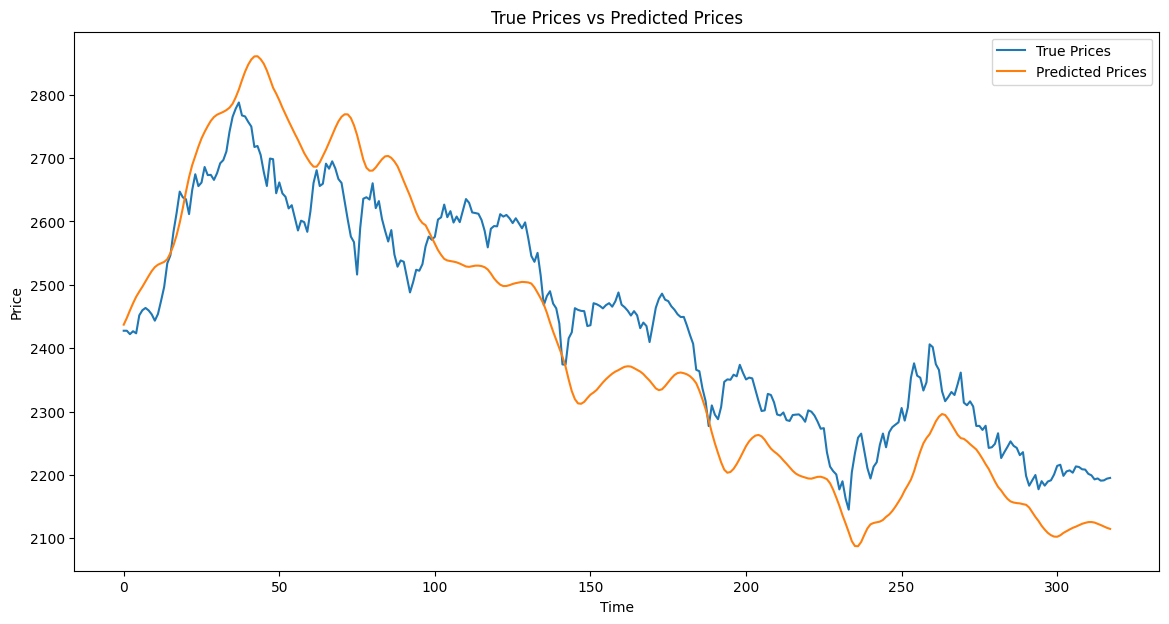

Accuracy of Predicted Prices: 87.03%


In [ ]:
import pandas as pd
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python random module
random.seed(42)

# Read the CSV file and sort by date
df = pd.read_csv('7new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

# Plot line charts
df_plot = df.copy()
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
    sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
    ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# List of considered Features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance',
            'Unemployment Rate', 'Exchange Rate', 'Economic Growth']

# Create the dataset with features and filter the data to the list of FEATURES
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Generate training data and test data
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Prediction is based on the 'Price' column
    return np.array(x), np.array(y)

# Generate training and test data
x, y = partition_dataset(sequence_length, data_scaled)
split = math.ceil(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

from keras.layers import Bidirectional

# Configure the neural network model
# Configure the neural network model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.15))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))


from keras.optimizers import Adam

# Compile the model with Adam optimizer and gradient clipping
optimizer = Adam(clipvalue=1.0)  # You can adjust the clip value as needed
model.compile(optimizer=optimizer, loss='mse')

# Define callbacks
#early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Training the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[reduce_lr])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate metrics
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))
mape = np.mean(np.abs((y_test_unscaled - y_pred) / y_test_unscaled)) * 100

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot true prices and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled, label='True Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title('True Prices vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate the absolute difference between true prices and predicted prices
absolute_difference = np.abs(y_test_unscaled - y_pred)

# Calculate the mean absolute difference
mean_absolute_difference = np.mean(absolute_difference)

# Calculate the range of prices
price_range = np.max(y_test_unscaled) - np.min(y_test_unscaled)

# Calculate accuracy in percentage
accuracy_percentage = (1 - (mean_absolute_difference / price_range)) * 100

print(f'Accuracy of Predicted Prices: {accuracy_percentage:.2f}%')


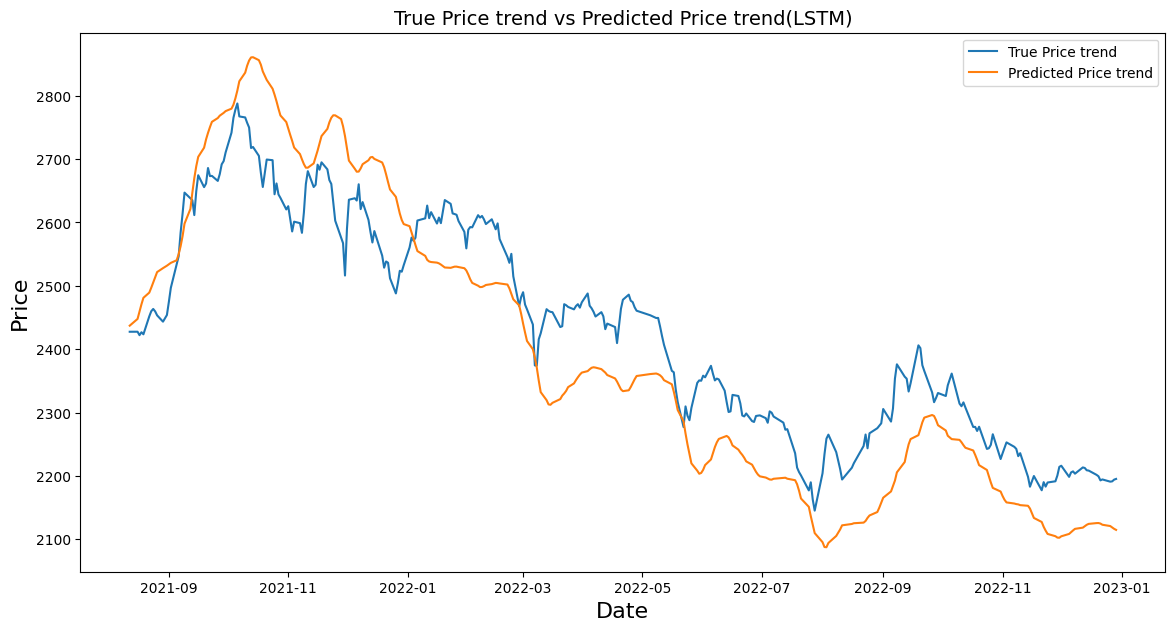

In [ ]:
# Plot true prices and predicted prices with dates on the x-axis
plt.figure(figsize=(14, 7))
plt.plot(df['Date'].iloc[-len(y_test_unscaled):], y_test_unscaled, label='True Price trend')
plt.plot(df['Date'].iloc[-len(y_pred):], y_pred, label='Predicted Price trend')
plt.title('True Price trend vs Predicted Price trend(LSTM)', fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.legend()
plt.show()


#bilstm   94.01


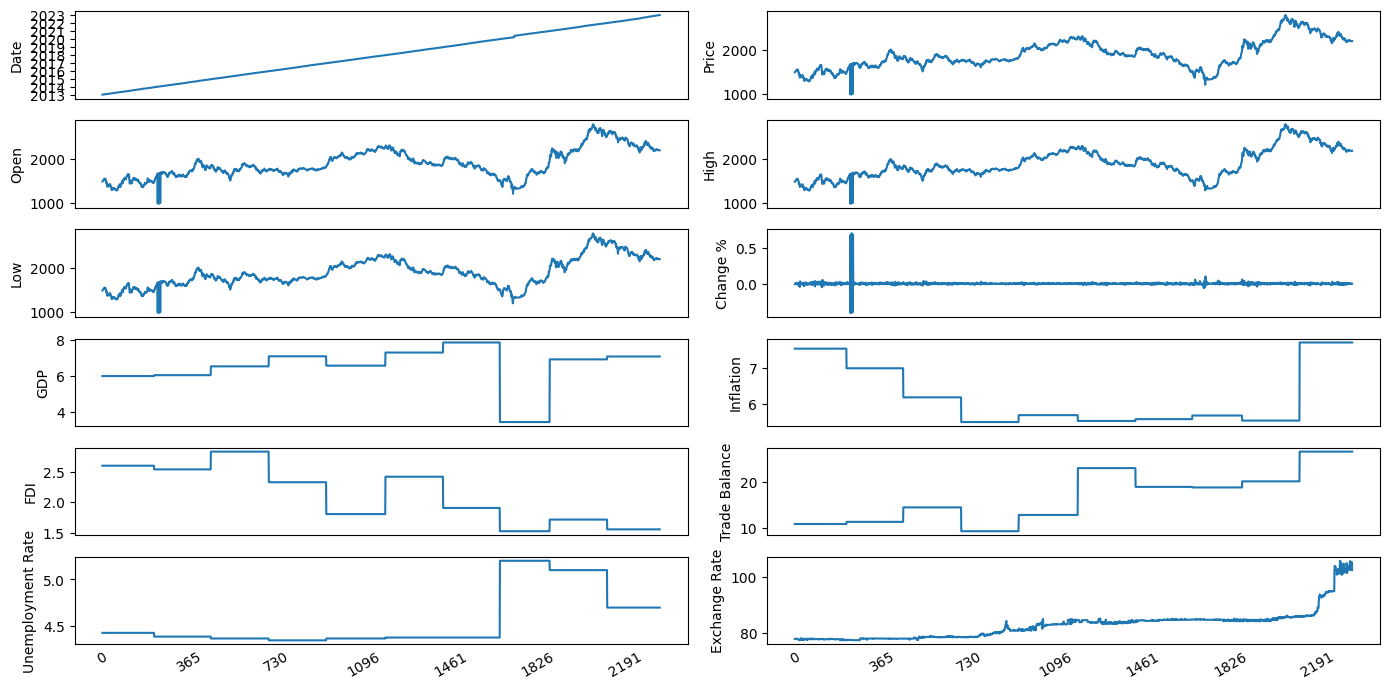

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 506ms/step - loss: 0.0511 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 501ms/step - loss: 0.0019 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 520ms/step - loss: 0.0014 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 560ms/step - loss: 0.0011 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 515ms/step - loss: 0.0011 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 506ms/step - loss: 9.7898e-04 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 43s 542ms/step - loss: 0.0011 - val_loss: 0.0036 - learning_rate: 2.0000e-04
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 538ms/step - loss: 9.2444e-04 - val_loss: 0.0041 - learning_rate: 2.0000e-04
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 521ms/step - loss: 8.7868e-04 - val_loss: 0.0045 - lea

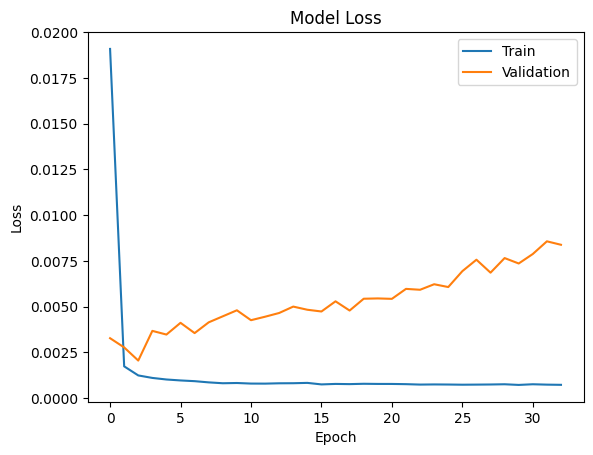

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step
Mean Squared Error (MSE): 19705.13
Root Mean Squared Error (RMSE): 140.37
Mean Absolute Error (MAE): 122.97
Mean Absolute Percentage Error (MAPE): 5.20%


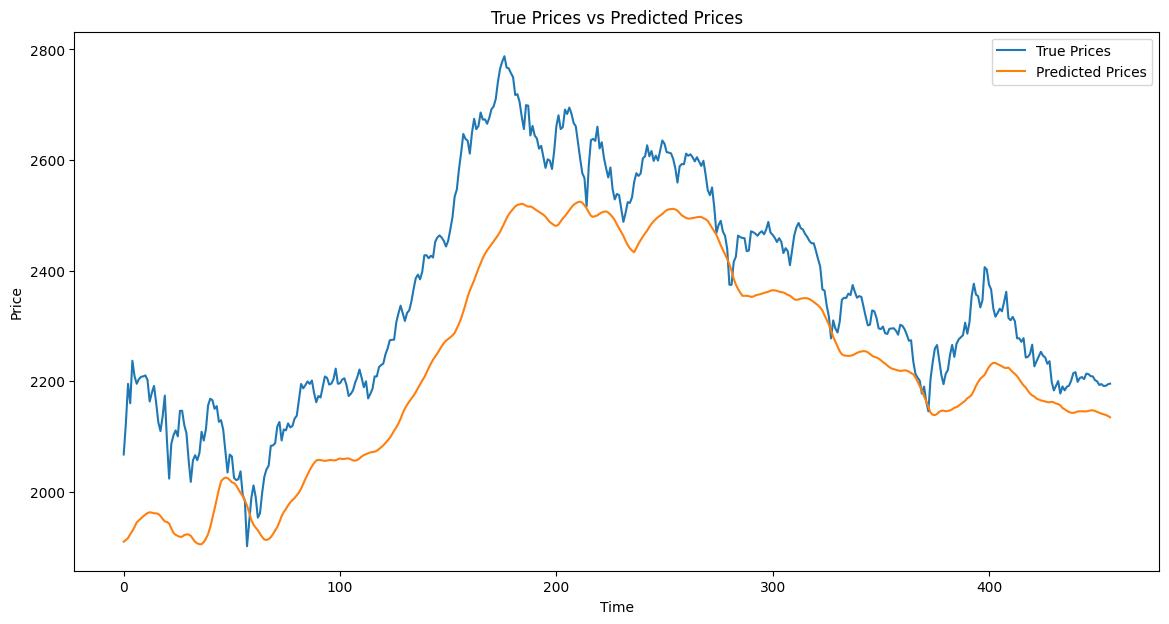

Accuracy of Predicted Prices: 86.13%


In [ ]:
import pandas as pd
import random
from keras.layers import Bidirectional
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python random module
random.seed(42)

# Read the CSV file and sort by date
df = pd.read_csv('new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

# Plot line charts
df_plot = df.copy()
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
    sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
    ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# List of considered Features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance',
            'Unemployment Rate', 'Exchange Rate', 'Economic Growth']

# Create the dataset with features and filter the data to the list of FEATURES
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Generate training data and test data
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Prediction is based on the 'Price' column
    return np.array(x), np.array(y)

# Generate training and test data
x, y = partition_dataset(sequence_length, data_scaled)
split = math.ceil(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Configure the neural network model
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.18))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.05))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile the model with Adam optimizer and gradient clipping
optimizer = Adam(clipvalue=1.0)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='mse')

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Training the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate metrics
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))
mape = np.mean(np.abs((y_test_unscaled - y_pred) / y_test_unscaled)) * 100

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot true prices and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled, label='True Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title('True Prices vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
# Calculate the absolute difference between true prices and predicted prices
absolute_difference = np.abs(y_test_unscaled - y_pred)

# Calculate the mean absolute difference
mean_absolute_difference = np.mean(absolute_difference)

# Calculate the range of prices
price_range = np.max(y_test_unscaled) - np.min(y_test_unscaled)

# Calculate accuracy in percentage
accuracy_percentage = (1 - (mean_absolute_difference / price_range)) * 100

print(f'Accuracy of Predicted Prices: {accuracy_percentage:.2f}%')

# gru10

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - loss: 0.0432 - val_loss: 9.8354e-04 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - loss: 8.6854e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - loss: 7.9533e-04 - val_loss: 9.4298e-04 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 384ms/step - loss: 7.4029e-04 - val_loss: 8.1707e-04 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 337ms/step - loss: 7.6631e-04 - val_loss: 9.1989e-04 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - loss: 7.3479e-04 - val_loss: 7.4730e-04 - learning_rate: 0.0010
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 433ms/step - loss: 7.1583e-04 - val_loss: 9.9106e-04 - learning_rate: 0.0010
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 353ms/step - loss: 6.9680e-04 - val_loss: 6.5723e-04 - learning_rate: 2.0000e-04
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step

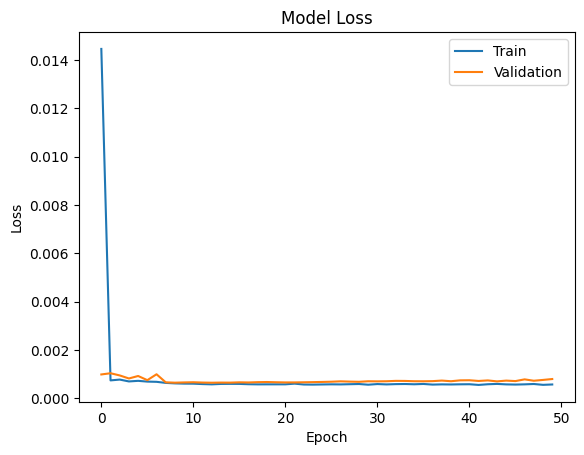

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
Mean Squared Error (MSE) - GRU: 6745.55
Root Mean Squared Error (RMSE) - GRU: 82.13
Mean Absolute Error (MAE) - GRU: 72.97
Mean Absolute Percentage Error (MAPE) - GRU: 3.07%


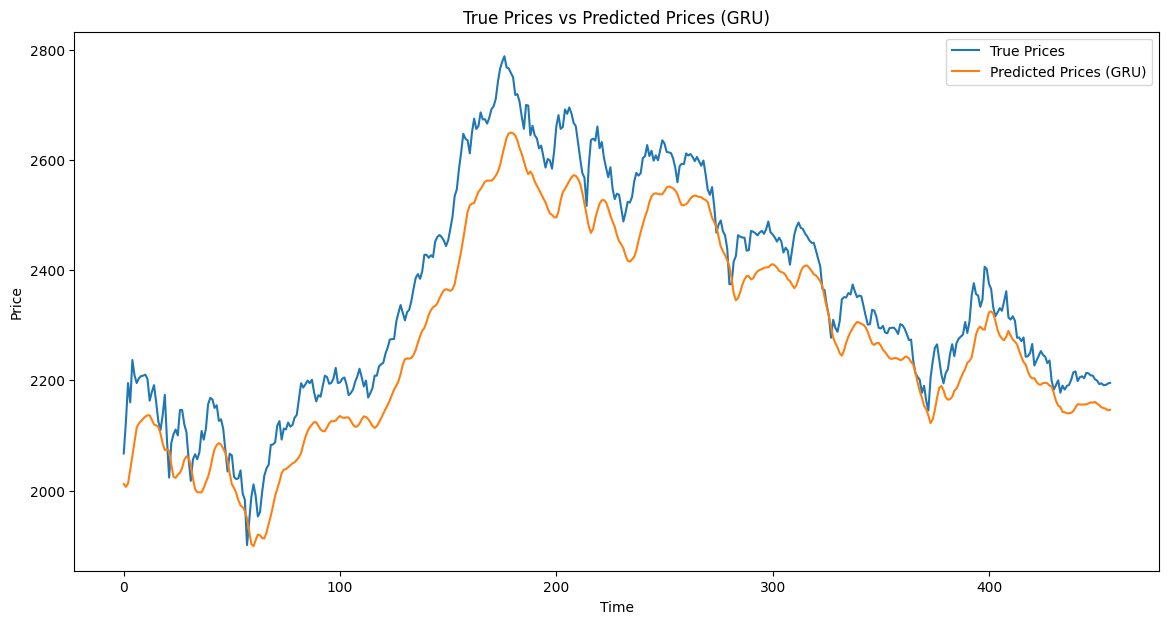

Accuracy of Predicted Prices (GRU): 91.77%
Mean Absolute Percentage Error (MAPE) - GRU: 3.07%


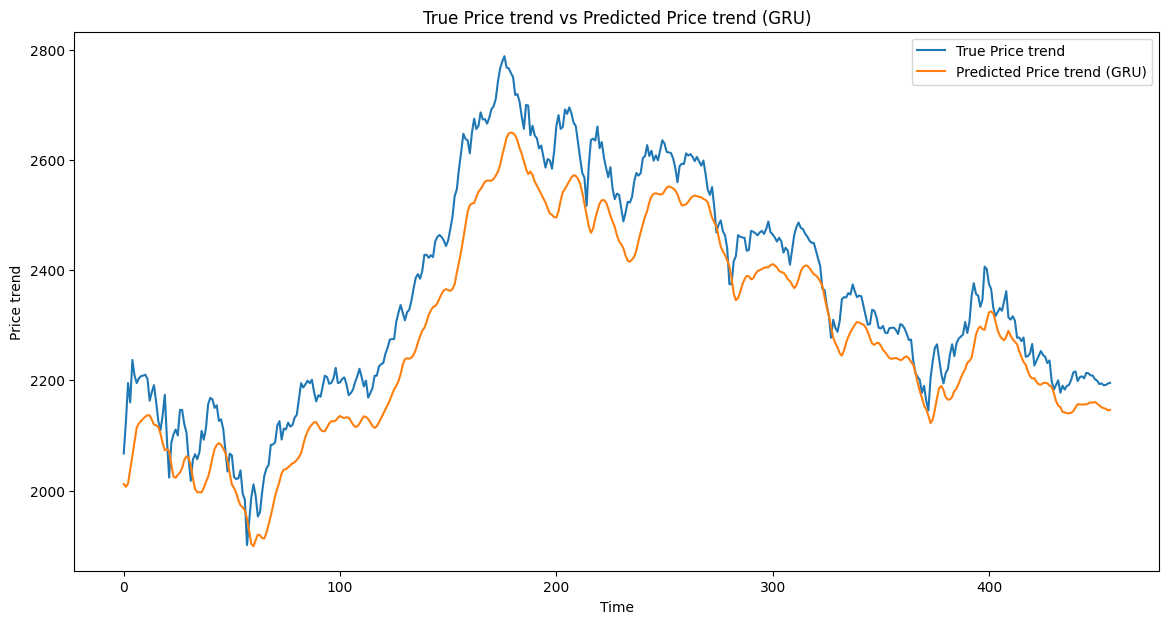

Accuracy of Predicted Prices (GRU): 91.77%


In [ ]:
import pandas as pd
import random
from keras.layers import GRU, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.dates as mdates
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python random module
random.seed(42)

# Read the CSV file and sort by date
df = pd.read_csv('new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

# List of considered Features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance',
            'Unemployment Rate', 'Exchange Rate', 'Economic Growth']

# Create the dataset with features and filter the data to the list of FEATURES
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Generate training data and test data
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Prediction is based on the 'Price' column
    return np.array(x), np.array(y)

# Generate training and test data
x, y = partition_dataset(sequence_length, data_scaled)
split = math.ceil(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Configure the GRU model
model_gru = Sequential()
model_gru.add(GRU(500, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_gru.add(Dropout(0.15))
model_gru.add(GRU(128, return_sequences=False))
#model_gru.add(Dropout(0.1))
model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(1))

# Compile the GRU model
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # You can adjust the clip value as needed
model_gru.compile(optimizer=optimizer, loss='mse')

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the GRU model
history_gru = model_gru.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[ reduce_lr])

# Plot training & validation loss values
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Get the predicted values
y_pred_scaled_gru = model_gru.predict(x_test)
y_pred_gru = scaler.inverse_transform(np.concatenate((y_pred_scaled_gru, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate metrics
mse_gru = mean_squared_error(y_test_unscaled, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru = np.mean(np.abs(y_test_unscaled - y_pred_gru))
mape_gru = np.mean(np.abs((y_test_unscaled - y_pred_gru) / y_test_unscaled)) * 100

print(f'Mean Squared Error (MSE) - GRU: {mse_gru:.2f}')
print(f'Root Mean Squared Error (RMSE) - GRU: {rmse_gru:.2f}')
print(f'Mean Absolute Error (MAE) - GRU: {mae_gru:.2f}')
print(f'Mean Absolute Percentage Error (MAPE) - GRU: {mape_gru:.2f}%')

# Plot true prices and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled, label='True Prices')
plt.plot(y_pred_gru, label='Predicted Prices (GRU)')
plt.title('True Prices vs Predicted Prices (GRU)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate the absolute difference between true prices and predicted prices
absolute_difference_gru = np.abs(y_test_unscaled - y_pred_gru)

# Calculate the mean absolute difference
mean_absolute_difference_gru = np.mean(absolute_difference_gru)

# Calculate the range of prices
price_range_gru = np.max(y_test_unscaled) - np.min(y_test_unscaled)

# Calculate accuracy in percentage
accuracy_percentage_gru = (1 - (mean_absolute_difference_gru / price_range_gru)) * 100

print(f'Accuracy of Predicted Prices (GRU): {accuracy_percentage_gru:.2f}%')

print(f'Mean Absolute Percentage Error (MAPE) - GRU: {mape_gru:.2f}%')

# Plot true prices and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled, label='True Price trend')
plt.plot(y_pred_gru, label='Predicted Price trend (GRU)')
plt.title('True Price trend vs Predicted Price trend (GRU)')
plt.xlabel('Time')
plt.ylabel('Price trend')
plt.legend()
plt.show()

# Calculate the absolute difference between true prices and predicted prices
absolute_difference_gru = np.abs(y_test_unscaled - y_pred_gru)

# Calculate the mean absolute difference
mean_absolute_difference_gru = np.mean(absolute_difference_gru)

# Calculate the range of prices
price_range_gru = np.max(y_test_unscaled) - np.min(y_test_unscaled)

# Calculate accuracy in percentage
accuracy_percentage_gru = (1 - (mean_absolute_difference_gru / price_range_gru)) * 100

print(f'Accuracy of Predicted Prices (GRU): {accuracy_percentage_gru:.2f}%')


In [ ]:
import pandas as pd
import random
from keras.layers import GRU, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python random module
random.seed(42)

# Read the CSV file and sort by date
df = pd.read_csv('7new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)
df.size()


In [ ]:
# List of considered Features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance',
            'Unemployment Rate', 'Exchange Rate', 'Economic Growth']

# Create the dataset with features and filter the data to the list of FEATURES
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Generate training data and test data
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Prediction is based on the 'Price' column
    return np.array(x), np.array(y)

# Generate training and test data
x, y = partition_dataset(sequence_length, data_scaled)
split = math.ceil(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]